# Text Classification with Word Embeddings

Contents:

* [1. Libraries](#1)
* [2. Text Cleaning](#2)
* [3. Bag of Words](#3)
* [4. Model](#4)
* [5. TF-IDF](#5)
* [6. Model](#6)

<a id="1"></a>
    
<font size="+2" color="indigo"><b>1. Libraries</b></font><br>

In [3]:
import pandas as pd
import numpy as np
import re 
import nltk 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold


from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')
import matplotlib.patches as mpatches

In [4]:
train=pd.read_csv("Corona_NLP_train.csv",encoding='latin1')
test=pd.read_csv("Corona_NLP_test.csv",encoding='latin1')

In [5]:
train['text'] = train.OriginalTweet
train["text"] = train["text"].astype(str)

test['text'] = test.OriginalTweet
test["text"] = test["text"].astype(str)

# Data has 5 classes, let's convert them to 3

def classes_def(x):
    if x ==  "Extremely Positive":
        return "2"
    elif x == "Extremely Negative":
        return "0"
    elif x == "Negative":
        return "0"
    elif x ==  "Positive":
        return "2"
    else:
        return "1"
    

train['label']=train['Sentiment'].apply(lambda x:classes_def(x))
test['label']=test['Sentiment'].apply(lambda x:classes_def(x))


train.label.value_counts(normalize= True)

2    0.438467
0    0.374128
1    0.187404
Name: label, dtype: float64

Let's encode Neutral as 0, Negative as 1, and Positive as 2

<a id="2"></a>
    
<font size="+2" color="indigo"><b>2. Text Cleaning</b></font><br>

In [6]:
#Remove Urls and HTML links
def remove_urls(text):
    url_remove = re.compile(r'https?://\S+|www\.\S+')
    return url_remove.sub(r'', text)
train['text_new']=train['text'].apply(lambda x:remove_urls(x))
test['text_new']=test['text'].apply(lambda x:remove_urls(x))

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
train['text']=train['text_new'].apply(lambda x:remove_html(x))
test['text']=test['text_new'].apply(lambda x:remove_html(x))

In [7]:
# Lower casing
def lower(text):
    low_text= text.lower()
    return low_text
train['text_new']=train['text'].apply(lambda x:lower(x))
test['text_new']=test['text'].apply(lambda x:lower(x))


# Number removal
def remove_num(text):
    remove= re.sub(r'\d+', '', text)
    return remove
train['text']=train['text_new'].apply(lambda x:remove_num(x))
test['text']=test['text_new'].apply(lambda x:remove_num(x))

In [8]:
#Remove stopwords & Punctuations
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))
STOPWORDS = set(stopwords.words('english'))

def punct_remove(text):
    punct = re.sub(r"[^\w\s\d]","", text)
    return punct
train['text_new']=train['text'].apply(lambda x:punct_remove(x))
test['text_new']=test['text'].apply(lambda x:punct_remove(x))


def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
train['text']=train['text_new'].apply(lambda x:remove_stopwords(x))
test['text']=test['text_new'].apply(lambda x:remove_stopwords(x))

In [9]:
#Remove mentions and hashtags
def remove_mention(x):
    text=re.sub(r'@\w+','',x)
    return text
train['text_new']=train['text'].apply(lambda x:remove_mention(x))
test['text_new']=test['text'].apply(lambda x:remove_mention(x))

def remove_hash(x):
    text=re.sub(r'#\w+','',x)
    return text
train['text']=train['text_new'].apply(lambda x:remove_hash(x))
test['text']=test['text_new'].apply(lambda x:remove_hash(x))

#Remove extra white space left while removing stuff
def remove_space(text):
    space_remove = re.sub(r"\s+"," ",text).strip()
    return space_remove
train['text_new']=train['text'].apply(lambda x:remove_space(x))
test['text_new']=test['text'].apply(lambda x:remove_space(x))
test = test.drop(columns=['text_new'])
train = train.drop(columns=['text_new'])

In [10]:
stop_words = ['a', 'an', 'the']

# Basic cleansing
def cleansing(text):
    # Tokenize
    tokens = text.split(' ')
    # Lower case
    tokens = [w.lower() for w in tokens]
    # Remove stop words
    tokens = [w for w in tokens if w not in stop_words]
    return ' '.join(tokens)

# All-in-one preproce
def preprocess_x(x):
    processed_x = [cleansing(text) for text in x]
    
    return processed_x

train['text_new']=train['text'].apply(lambda x:preprocess_x(x))
test['text_new']=test['text'].apply(lambda x:preprocess_x(x))

<a id="3"></a>
    
<font size="+2" color="indigo"><b>3. Bag of Words</b></font><br>

In [11]:
X = train["text"].tolist()
y = train["label"].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.10,
                                                    random_state = 0)

In [30]:
BOW = CountVectorizer(min_df=5,stop_words='english')

# We transform each text into a vector
features = BOW.fit_transform(train.text).toarray()

labels = train.label

print("Each of the %d tweets is represented by %d features" %(features.shape))

Each of the 41157 tweets is represented by 10615 features


<a id="4"></a>
    
<font size="+2" color="indigo"><b>4. Models</b></font><br>

In [16]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

C:\Users\sachi\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\sachi\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\sachi\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\sachi\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [18]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.758802,0.002095
MultinomialNB,0.679544,0.005714
RandomForestClassifier,0.472386,0.002999


### As we can see Linear SVM has the highest accuracy of 75%, followed by Naive Bayes. It's shocking to see Random Forest with the least accuracy

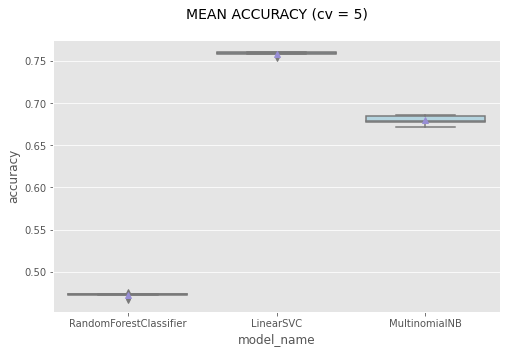

In [19]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

In [20]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               train.index, test_size=0.10, 
                                                               random_state=1)
model =   LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)



In [21]:
# Classification report

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= train['label'].unique()))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

           1       0.78      0.77      0.77      1554
           2       0.64      0.67      0.65       760
           0       0.81      0.81      0.81      1802

    accuracy                           0.77      4116
   macro avg       0.74      0.75      0.75      4116
weighted avg       0.77      0.77      0.77      4116



### We see low F1 scores for Positive (2) tweets as compared to Negative (0) and Neutral (1)

    Precison = True Positive / (True Positive + False Positive) = True Positive / All Predicted Positive
Precision talks about how precise/accurate your model is out of those predicted positive, how many of them are actual positive. Precision is a good measure to determine, when the costs of False Positive is high. For instance, email spam detection.

    Recall = True Positive / (True Positive + False Negative) = True Positive / All Actual Positive
Recall actually calculates how many of the Actual Positives our model capture through labeling it as Positive (True Positive). Recall shall be the model metric we use to select our best model when there is a high cost associated with False Negative. For instance, in fraud detection or sick patient detection. 

    F1 =  2 * (Precision * Recall) / (Precision + Recall)
F1 Score might be a better measure to use if we need to seek a balance between Precision and Recall AND there is an uneven class distribution (large number of Actual Negatives).

In [22]:
# Create a new column 'category_id' with encoded categories 

def classes_def(x):
    if x ==  "Extremely Positive":
        return "Positive"
    elif x == "Extremely Negative":
        return "Negative"
    elif x == "Negative":
        return "Negative"
    elif x ==  "Positive":
        return "Positive"
    else:
        return "Neutral"
    

train['sentiment']=train['Sentiment'].apply(lambda x:classes_def(x))


sentiment_id_df= train[["sentiment",'label']].drop_duplicates()

# Dictionaries for future use


sentiment_to_id = dict(sentiment_id_df.values)
id_to_sentiment = dict(sentiment_id_df[["sentiment",'label']].values)


sentiment_id_df


,sentiment,label
0,Neutral,1
1,Positive,2
4,Negative,0


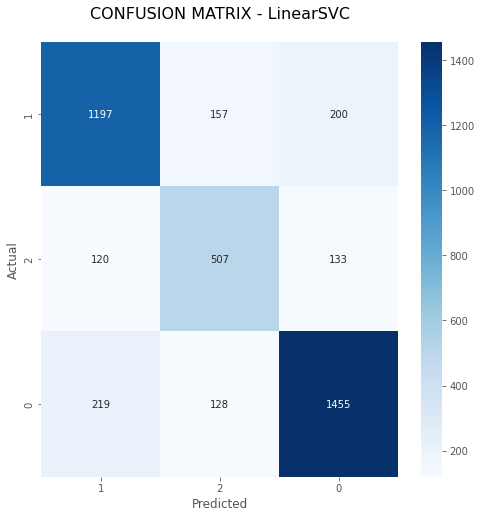

In [23]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=sentiment_id_df.label.values, 
            yticklabels=sentiment_id_df.label.values)
train = train.drop(columns=['sentiment'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

<a id="5"></a>
    
<font size="+2" color="indigo"><b>5. TF-IDF</b></font><br>

In [24]:
X = train["text"].tolist()
y = train["label"].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.10,
                                                    random_state = 0)

In [27]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english')

# We transform each text into a vector
features = tfidf.fit_transform(train.text).toarray()

labels = train.label

print("Each of the %d tweets is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 41157 tweets is represented by 22725 features (TF-IDF score of unigrams and bigrams)


In [28]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [29]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.767087,0.004724
MultinomialNB,0.652647,0.003813
RandomForestClassifier,0.464027,0.012082


In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

In [ ]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               train.index, test_size=0.10, 
                                                               random_state=1)
model =   LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
# Classification report

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= train['label'].unique()))